# Grad-CAM with PyTorch

In [1]:
import os
import torch
from torch import nn
from torchvision import models, transforms
from gradcam import GradCAM

## Model Loading

In [2]:
image_model_path = "./fire.model"
image_save_point = torch.load(image_model_path)
image_model = models.resnet34(pretrained=False, num_classes=2)
image_model.load_state_dict(image_save_point['state_dict'])
id_to_label = {
    0: 'other',
    1: 'fire'
}

## Preprocess Image



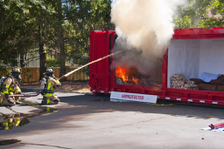

In [3]:
from PIL import Image
from torchvision.transforms.functional import to_pil_image

VISUALIZE_SIZE = (224, 224)  # size for visualize

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

image_transform = transforms.Compose([
        transforms.Resize(VISUALIZE_SIZE),
        transforms.ToTensor(),
        normalize])

path = "./fire.jpg"
image = Image.open(path)
image.thumbnail(VISUALIZE_SIZE, Image.ANTIALIAS)
display(image)

# save image origin size
image_orig_size = image.size # (W, H)

img_tensor = image_transform(image)
img_tensor = img_tensor.unsqueeze(0)

## Put Image in grad-cam

In [4]:
grad_cam = GradCAM(model=image_model, feature_layer=list(image_model.layer4.modules())[-1])

In [5]:
model_output = grad_cam.forward(img_tensor)
target = model_output.argmax(1).item()

force target value

In [6]:
# target = 0

## Backprop in Grad-CAM

In [7]:
grad_cam.backward_on_target(model_output, target)

get weights and feature map

In [8]:
import numpy as np
# Get feature gradient
feature_grad = grad_cam.feature_grad.data.numpy()[0]
# Get weights from gradient
weights = np.mean(feature_grad, axis=(1, 2))  # Take averages for each gradient
# Get features outputs
feature_map = grad_cam.feature_map.data.numpy()
grad_cam.clear_hook()

compute the cam

In [9]:
# Get cam
cam = np.sum((weights * feature_map.T), axis=2).T
cam = np.maximum(cam, 0)  # apply ReLU to cam

## Visualize

In [10]:
import cv2
cam = cv2.resize(cam, VISUALIZE_SIZE)
cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
activation_heatmap = np.expand_dims(cam, axis=0).transpose(1,2,0)
org_img = np.asarray(image.resize(VISUALIZE_SIZE))
img_with_heatmap = np.multiply(np.float32(activation_heatmap), np.float32(org_img))
img_with_heatmap = img_with_heatmap / np.max(img_with_heatmap)
org_img = cv2.resize(org_img, image_orig_size)

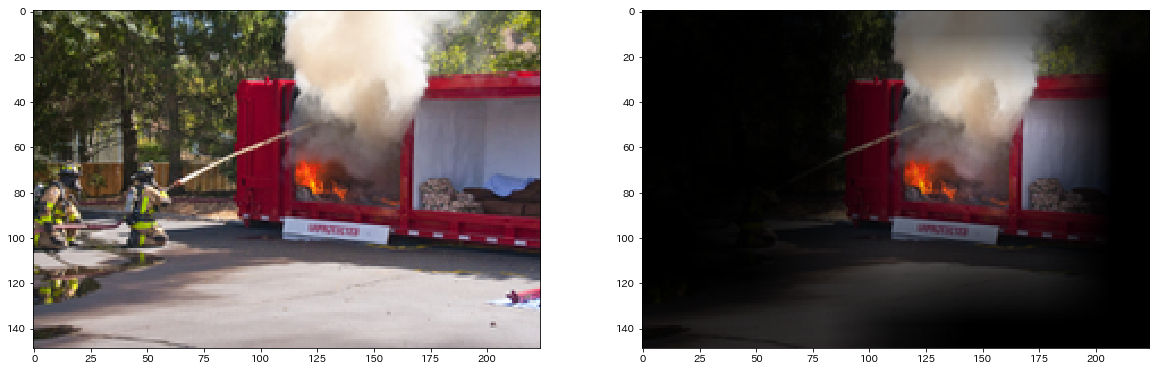

{'other': 0.01, 'fire': 0.99}
Predict Class: fire


In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(org_img)
plt.subplot(1,2,2)
plt.imshow(cv2.resize(np.uint8(255 * img_with_heatmap), image_orig_size))
plt.show()
result = nn.Softmax(dim=0)(model_output[0]).data.tolist()
print({id_to_label[i]: round(score, 4) for i, score in enumerate(result)})
print("Predict Class:", id_to_label[target])